In [4]:
!pip install tensorflow

  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Created wheel for jax: filename=jax-0.4.13-py3-none-any.whl size=1518835 sha256=1c4283d34571506b4e8dc66816831ce93170883d526300cad1ecbfe674371d4e
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\ac\c9\8c\f4c803770fde18dcdd82e84675eb6add1c0d1035f7214a96fa
Successfully built jax
  Using cached tensorflow-2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.11.1


In [4]:
df = pd.read_csv('Data/GlobalTemperatures.csv')
df = df.drop(columns=['LandAverageTemperatureUncertainty','LandMaxTemperatureUncertainty','LandMinTemperatureUncertainty','LandAndOceanAverageTemperatureUncertainty'])
df['dt'] = pd.to_datetime(df['dt'])
df['year'] = df['dt'].dt.year
df = df.drop('dt',axis=1)
df = df.dropna()
df = df.groupby('year').agg({'LandAndOceanAverageTemperature':np.mean}).reset_index()

In [11]:
df.to_excel('./Data/processedData.xlsx', index=False)

In [7]:
df.to_json('./Data/processedData.json')

c:\Users\asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


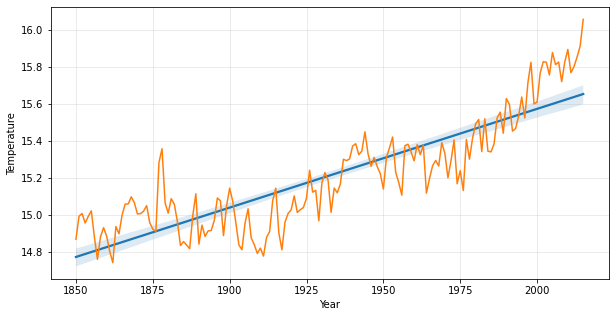

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(df['year'],df['LandAndOceanAverageTemperature'],scatter=False,ax=ax)
plt.plot(df['year'],df['LandAndOceanAverageTemperature'])
plt.ylabel('Temperature')
# plt.xticks(fontsize=20,rotation='vertical')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [10]:
x_train = train_dataset[['year']]
y_train = train_dataset['LandAndOceanAverageTemperature']
x_test = test_dataset[['year']]
y_test = test_dataset['LandAndOceanAverageTemperature']

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [12]:
normalizer.adapt(np.array(x_train))

In [13]:
year_normalizer = layers.Normalization(input_shape=[1,], axis=None)
year_normalizer.adapt(x_train)

In [14]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [15]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [16]:
dnn_model = build_and_compile_model(year_normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [17]:
%%time
history = dnn_model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 3.76 s


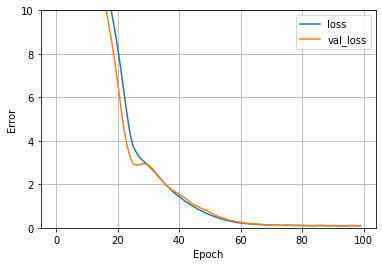

In [18]:
plot_loss(history)

In [19]:
x = tf.linspace(1850, 2015, 166)
y = dnn_model.predict(x)

6/6 [==============================] - 0s 1ms/step


In [21]:
def plot_temp(x, y):
  plt.scatter(x_train, y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Year')
  plt.ylabel('Temp')
  plt.legend()

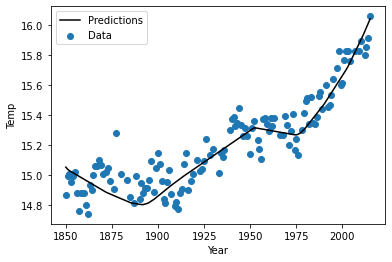

In [22]:
plot_temp(x,y)

In [23]:
dnn_model.evaluate(x_test, y_test, verbose=0)

0.12417487055063248

2/2 [==============================] - 0s 2ms/step


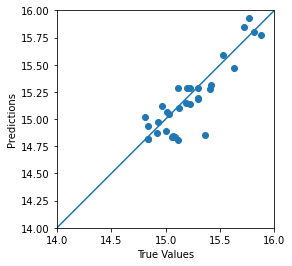

In [24]:
test_predictions = dnn_model.predict(x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [14, 16]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

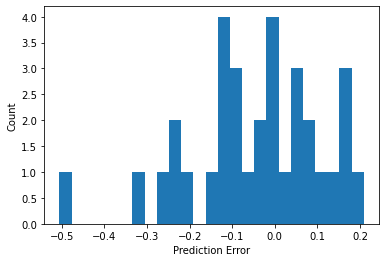

In [25]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [56]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


INFO:tensorflow:Assets written to: dnn_model\assets


In [26]:
import tensorflowjs as tfjs

In [29]:
tfjs.converters.convert_tf_saved_model('./dnn_model','./web_dnn_model')

Writing weight file ./web_dnn_model\model.json...


In [ ]:
# reloaded = tf.keras.models.load_model('dnn_model')

# test_results['reloaded'] = reloaded.evaluate(
#     test_features, test_labels, verbose=0)

In [1]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.3
    Uninstalling protobuf-4.23.3:
      Successfully uninstalled pro

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdfservices-sdk 2.2.0 requires packaging==21.3, but you have packaging 20.9 which is incompatible.
